In [1]:
### import the packages we'll need
import numpy as np
from matplotlib import pyplot as plt

path = '/Users/zachary/Dropbox/school/courses/CMU/2019Fall/88-275_bubbles_2019F/masterclass'

with open(path + '/stopwords.txt') as file:
    stopwords = file.readlines()
    stopwords = [i[:-1] for i in stopwords]

def dump(location,item):
    with open(path + location, 'w') as fp:
        json.dump(item, fp)
        
def load(location):
    with open(path + location) as json_file:
        data = json.load(json_file)
    return data

# scraping artist lists from wikipedia

In [2]:
import requests
import random
from bs4 import BeautifulSoup

In [4]:
# grab the html for wikipedia's list of west coast artists & parse with beautifulsoup
r_west = requests.get('https://en.wikipedia.org/wiki/List_of_West_Coast_hip_hop_artists')
html_west = r_west.text
soup_west = BeautifulSoup(html_west, 'html.parser')

# print(soup_west.prettify())

In [5]:
# split the page into list blocks and grab the artist names from each 
artists_west = []

for block in soup_west.find_all(attrs={'class': 'div-col columns column-width'}):
    for item in block.find_all('li'):
        try:
            artists_west.append(item.a['title'])
        except:
            pass

random.shuffle(artists_west)
print(artists_west[:5])

['Ahmad (rapper)', 'Marvaless', 'Stat Quo', 'Knight Owl', 'Anotha Level']


In [6]:
# because east coast musicians are split over three pages, we define a function that can be applied to each
def grab_east(page):
    r_east = requests.get(page)
    html_east = r_east.text
    soup_east = BeautifulSoup(html_east, 'html.parser')

    foo = []

    for block in soup_east.find_all(attrs={'class': 'mw-category'}):
        for item in block.find_all('li'):
            try:
                foo.append(item.a['title'])
            except:
                pass

    foo = [i for i in foo if i[:8]!='Category']
    return foo

artists_east = grab_east('https://en.wikipedia.org/wiki/Category:East_Coast_hip_hop_musicians')
artists_east = artists_east + grab_east('https://en.wikipedia.org/w/index.php?title=Category:East_Coast_hip_hop_musicians&pagefrom=Kool+G+Rap%0AKool+G+Rap#mw-pages')
artists_east = artists_east + grab_east('https://en.wikipedia.org/w/index.php?title=Category:East_Coast_hip_hop_musicians&pagefrom=Watts%2C+Ohmega%0AOhmega+Watts#mw-pages')

random.shuffle(artists_east)
print(artists_east[:5])

['McGruff (rapper)', 'Swizz Beatz', 'AZ (rapper)', 'East Flatbush Project', 'Black Child']


# pulling lyrics from the genius api 

In [7]:
import lyricsgenius
import random
import json

### create a genius api object
# Note! To use this code, you need a genius api authorization key. 
# To get one, just create a genius account, then go to https://docs.genius.com/#/getting-started-h1
# You should see a long string next to the words "Authorization Bearer" on the right-hand side.
# It will look something like "SLDIiajsddkDIDNslksdkNANDLd_kasdkfja_a920akdkfnal"
# Copy and paste that bad boy below

genius_key = "j1zXUFoiUM64WoRDpHAfvwXKAY5X2dIlkJTcIbbHdY_UBahhGYN_o8S4jDqNTi1W"
genius = lyricsgenius.Genius(genius_key)

In [8]:
def pull_data(l,f):
    data = []
    
    for artist_name in l:
        try:
            artist = genius.search_artist(artist_name, max_songs=5, sort='popularity')
            if artist:
                for song in artist.songs:
                    data_point = {}
                    data_point['artist'] = artist.name
                    data_point['lyrics'] = song.lyrics
                    data_point['date'] = song.year
                    data_point['title'] = song.title
                    data.append(data_point)

            dump(f,data)
        except:
            print('exception: {}'.format(artist.name))
            pass
    
        
### use these functions to pull the data and write it to the hard drive
# pull_data(artists_east,'/data_east.json')
# pull_data(artists_west,'/data_west.json')

# cleaning data

In [10]:
import re
import collections

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

east = pd.read_json(path+'/data_east.json')
west = pd.read_json(path+'/data_west.json')

In [11]:
def clean(text):
    ### clean a lyric string
    # split string into lines
    text = text.split('\n')
    # drop missing lines
    text = [i for i in text if i]
    # drop bracketed lines (e.g. producer info, song part indicators)
    text = [i for i in text if i[0]!='[']
    # join back into single string
    text = ' '.join(text)
    # filter out non-alpha-numeric characters 
    text = re.sub(r'[^\s\w]+', '', text)
    # strip capitalization
    text = text.lower()
    # drop stopwords
    text = ' '.join([i for i in text.split() if i not in stopwords])
    return text

def H(p):
    # calculate the entropy of a numpy array
    p = p/p.sum()
    return (-p*np.log(p)).mean()

def calc_H(text):
    ### calculate entropy of a piece of text
    # split into words
    words = text.split(' ')
    # use a counter to count the occurances of each word
    counter = collections.Counter(words)
    counts = counter.values()
    counts = np.array(list(counts))
    probs = counts/counts.sum()
    # apply our entropy function
    return H(probs)

In [12]:
# drop entries that are missing lyrics or dates
west = west[west['lyrics'].notna()&west['date'].notna()]
east = east[east['lyrics'].notna()&east['date'].notna()]

# clean the text
east['lyrics'] = [clean(i) for i in east['lyrics']]
west['lyrics'] = [clean(i) for i in west['lyrics']]

# # drop outlier
# west = west[west['lyrics']!='please add this song']

# grab years
west['year'] = pd.DatetimeIndex(west['date']).year
east['year'] = pd.DatetimeIndex(east['date']).year

# calculate entropy
west['entropy'] = [calc_H(i) for i in west['lyrics'].tolist()]
east['entropy'] = [calc_H(i) for i in east['lyrics'].tolist()]

west.head()

,artist,date,lyrics,title,year,entropy
1,Charli Baltimore,1998-06-08,way sound intro camron noreaga ya heard yo b d...,N.B.C.,1998,0.019806
2,Charli Baltimore,1999-08-03,yeah charli baltimore bout lay muthafuckas cha...,Everybody Wanna Know,1999,0.023972
5,Killa Sin,2012-10-22,snake charmer best work yet however next job e...,The Archer,2012,0.021097
6,Wiz Khalifa,2015-03-09,long day without friend ill tell see weve come...,See You Again,2015,0.046046
7,Wiz Khalifa,2012-09-24,shes earn bragging rights im bout give like iv...,Remember You,2012,0.027789


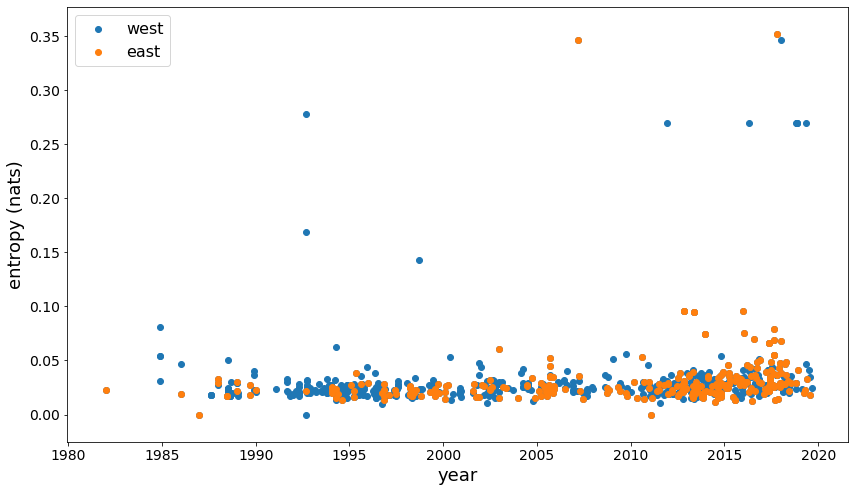

In [13]:
# create a figure of entropy by date for each coast

plt.figure(figsize=(14,8))
           
plt.scatter(west['date'],west['entropy'],label='west')
plt.scatter(east['date'],east['entropy'],label='east')

plt.xlabel('year',size=18)
plt.ylabel('entropy (nats)',size=18)
plt.tick_params(labelsize=14)
plt.legend(loc='upper left',prop={'size': 16})

In [14]:
# add counts for the number of words and number of unique words

west['n_words'] = [len(i.split(' ')) for i in west['lyrics']]
east['n_words'] = [len(i.split(' ')) for i in east['lyrics']]

west['n_words_unique'] = [len(set(i.split())) for i in west['lyrics']]
east['n_words_unique'] = [len(set(i.split())) for i in east['lyrics']]

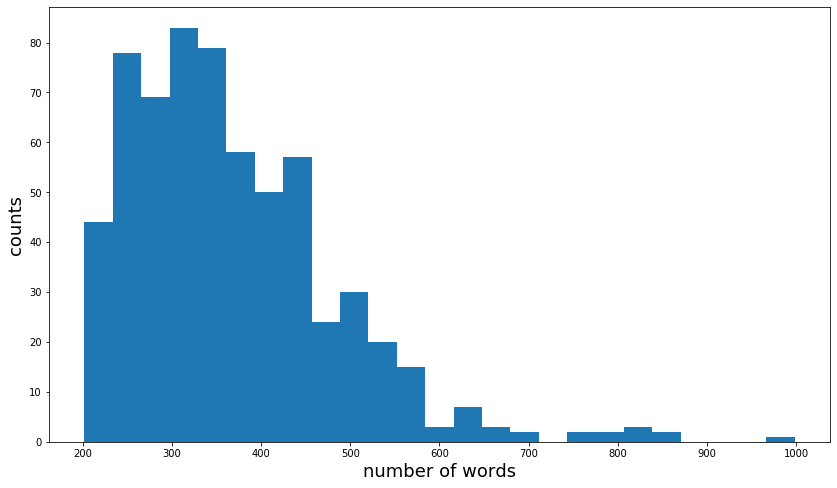

In [33]:
# histogram of lyrics by number of words

plt.figure(figsize=(14,8))

plt.hist(west['n_words'],bins=25)
plt.xlabel('number of words',size=18)
plt.ylabel('counts',size=18);

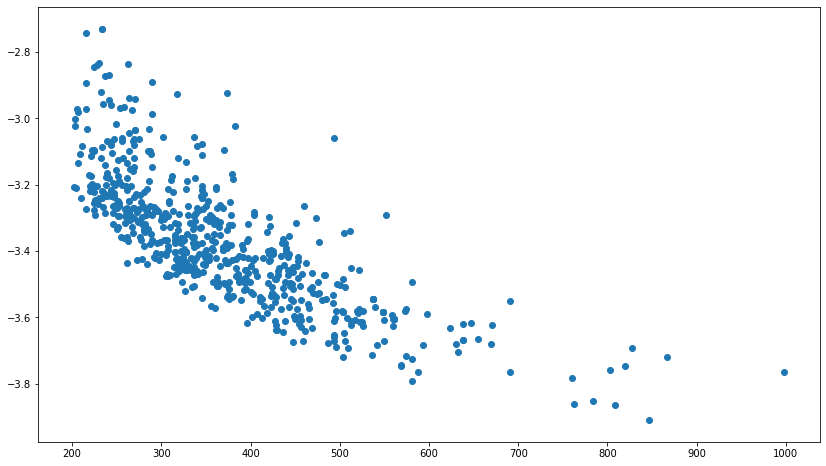

In [35]:
# plot of entropy against number of words... notice there is a relationship!

plt.figure(figsize=(14,8))

plt.scatter(west['n_words'],np.log(west['entropy']+.01))

In [39]:
# filter small-word outliers (mostly missing/garbage text)

west = west[west['n_words']>=300]
east = east[east['n_words']>=300]

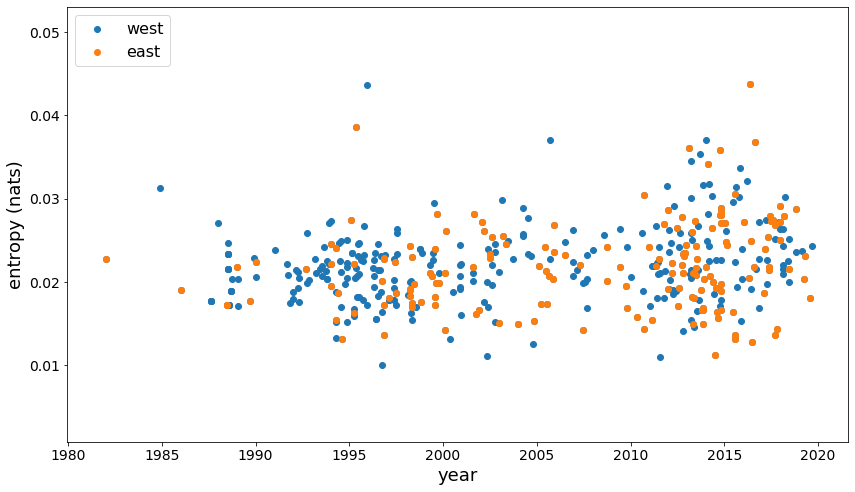

In [40]:
plt.figure(figsize=(14,8))
           
plt.scatter(west['date'],west['entropy'],label='west')
plt.scatter(east['date'],east['entropy'],label='east')

plt.xlabel('year',size=18)
plt.ylabel('entropy (nats)',size=18)
plt.tick_params(labelsize=14)
plt.legend(loc='upper left',prop={'size': 16})

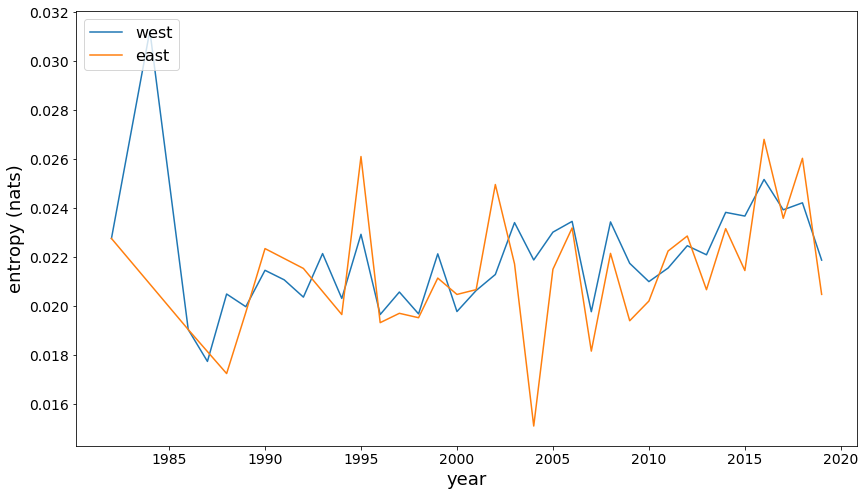

In [42]:
plt.figure(figsize=(14,8))

west_yearly = west.groupby('year').mean().reset_index()
east_yearly = east.groupby('year').mean().reset_index()

plt.plot(west_yearly['year'],west_yearly['entropy'],label='west')
plt.plot(east_yearly['year'],east_yearly['entropy'],label='east')

plt.xlabel('year',size=18)
plt.ylabel('entropy (nats)',size=18)
plt.tick_params(labelsize=14)
plt.legend(loc='upper left',prop={'size': 16})

In [46]:
# get the highest average entropy artist on the west coast

west.groupby('artist').mean().sort_values('entropy',ascending=False).head()

,year,entropy,n_words,n_words_unique
artist,,,,
Maleek Berry,2014.5,0.039917,359.0,105.5
Kid Ink,2013.5,0.033556,341.0,126.0
Sage The Gemini,2013.0,0.032346,346.0,130.0
070 Shake,2016.0,0.032065,449.0,140.0
Lil Durk,2016.5,0.031957,328.0,138.5


In [47]:
# concatenate all lyrics from a given year into a giant string and then calculate entropy
# (rather than calculating entropy for each song separately, then averaging)

for year in west['year'].unique():
    big_string = ' '.join(west[west['year']==year]['lyrics'].tolist())
    west_yearly.loc[west_yearly['year']==year,'lyrics'] = big_string
    west_yearly.loc[west_yearly['year']==year,'entropy_all'] = calc_H(big_string)
    
for year in east['year'].unique():
    big_string = ' '.join(east[east['year']==year]['lyrics'].tolist())
    east_yearly.loc[east_yearly['year']==year,'lyrics'] = big_string
    east_yearly.loc[east_yearly['year']==year,'entropy_all'] = calc_H(big_string)

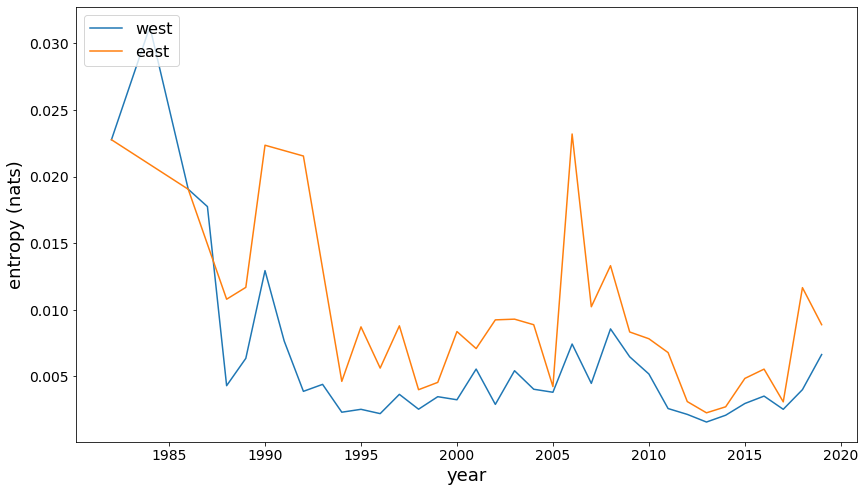

In [48]:
plt.figure(figsize=(14,8))

plt.plot(west_yearly['year'],west_yearly['entropy_all'],label='west')
plt.plot(east_yearly['year'],east_yearly['entropy_all'],label='east')

plt.xlabel('year',size=18)
plt.ylabel('entropy (nats)',size=18)
plt.tick_params(labelsize=14)
plt.legend(loc='upper left',prop={'size': 16})

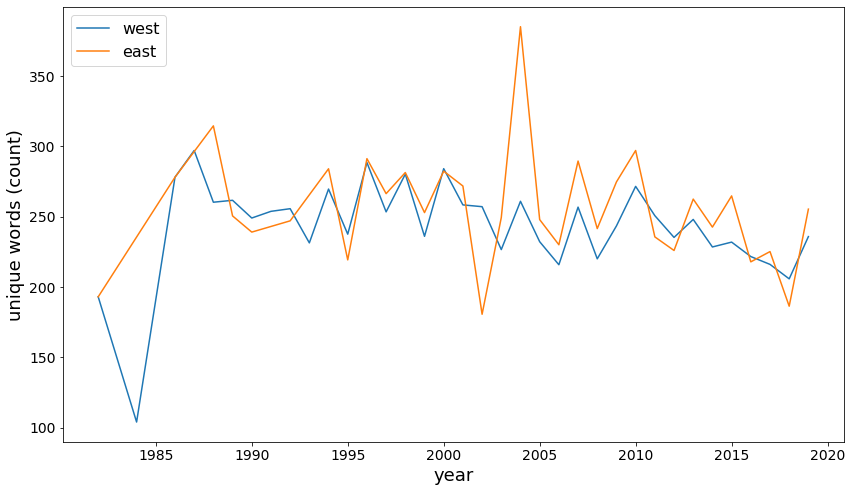

In [50]:
# plot of number of unique words over time

plt.figure(figsize=(14,8))

plt.plot(west_yearly['year'],west_yearly['n_words_unique'],label='west')
plt.plot(east_yearly['year'],east_yearly['n_words_unique'],label='east')

plt.xlabel('year',size=18)
plt.ylabel('unique words (count)',size=18)
plt.tick_params(labelsize=14)
plt.legend(loc='upper left',prop={'size': 16})

In [55]:
### calculate the JSD between the two coasts over time

# create a giant string containing ALL lyrics in our sample
lyrics_all = ' '.join(west_yearly['lyrics'].tolist()+east_yearly['lyrics'].tolist())
# create a list of all the words that appear anywhere in our sample
words_all = list(set(lyrics_all.split(' ')))
# create a counter with all our words set to zero counts
words_all.sort()
words_all = collections.Counter(words_all)
for word in words_all.elements():
    words_all[word] = 0
    
def get_dist(text,normalize=True):
    # function to grab a text's probability distribution over these words
    counter = words_all.copy()
    counter.update(text.split(' '))
    p = np.array(list(counter.values()))+1
    if normalize:
        p = p/p.sum()
    return p

def kld(p,q):
    # function to calculate the KLD between two numpy arrays
    p = p/p.sum()
    q = q/q.sum()
    return (p*np.log(p/q)).mean()

In [56]:
# apply our distribution function to calculate distributions for song lyrics on a yearly basis

west_yearly['dist'] = [get_dist(i) for i in west_yearly['lyrics'].tolist()]
east_yearly['dist'] = [get_dist(i) for i in east_yearly['lyrics'].tolist()]

In [57]:
# get a unique, sorted list of the years that appear in our sample (greater than 1988)

years_west = west_yearly['year'].tolist()
years_east = east_yearly['year'].tolist()
years = list(set(years_west).intersection(set(years_east)))
years = [year for year in years if year>=1988]
years.sort()

In [58]:
# apply our JSD function on a yearly basis to the distributions we calculated above

res = []

for year in years:
    west_dist = west_yearly[west_yearly['year']==year]['dist'].tolist()[0]
    east_dist = east_yearly[east_yearly['year']==year]['dist'].tolist()[0]
    mid_dist = (east_dist + west_dist)/2
    jsd = (kld(west_dist,mid_dist) + (kld(east_dist,mid_dist)))/2
    res.append(jsd)

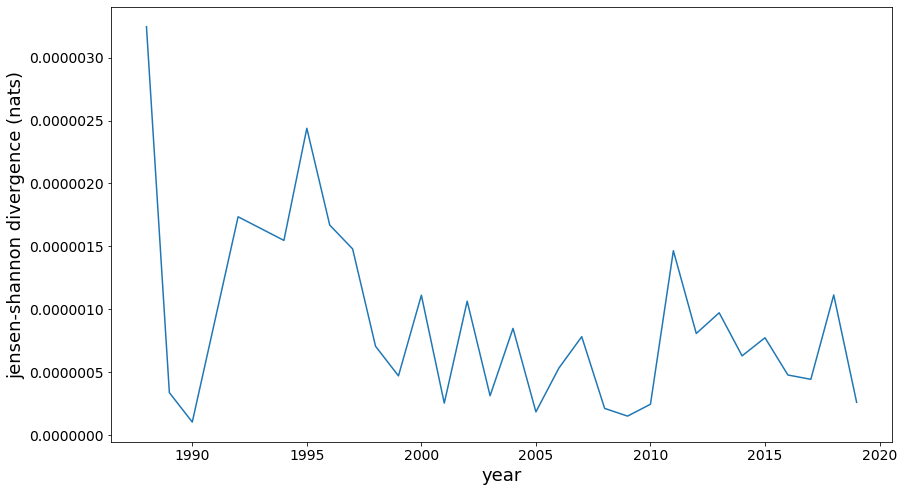

In [59]:
# plot JSD over time

plt.figure(figsize=(14,8))

plt.plot(years,res)

plt.xlabel('year',size=18)
plt.ylabel('jensen-shannon divergence (nats)',size=18)
plt.tick_params(labelsize=14)

# logistic regression

In [60]:
# import a logistic regession object from SciKit (see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
from sklearn.linear_model import LogisticRegression

In [64]:
# apply our function to get *unnormalized* distributions over words (i.e., just counts)

west['dist'] = [get_dist(i,normalize=False) for i in west['lyrics'].tolist()]
east['dist'] = [get_dist(i,normalize=False) for i in east['lyrics'].tolist()]

# conform to matrices for scikit

x_west = np.array(west['dist'].tolist())
x_east = np.array(east['dist'].tolist())
x = np.vstack((x_west,x_east))
y = np.hstack((np.zeros(x_west.shape[0]),np.ones(x_east.shape[0])))

In [106]:
# apply our logit function
logit = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(x, y)

coefs = logit.coef_.ravel()

/Users/zachary/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [107]:
def prominent_words(coefs,n):
    # function to grab n words with the largest coefficient (i.e., greatest predictive power) in the logit  
    coefs_sorted = np.argpartition(coefs, -n)[-n:]
    coefs_sorted = coefs_sorted[np.argsort(-coefs[coefs_sorted])]
    return [list(dict(words_all).keys())[i] for i in coefs_sorted]

In [108]:
# grab 10 prominent east-coast words

print('prominent words, east:')
print(prominent_words(coefs,10))

prominent words, east:
['could', 'uptown', 'dirty', 'never', 'rap', 'running', 'though', 'party', 'die', 'kid']


In [109]:
# grab 10 prominent west-coast words

print('prominent words, west:')
print(prominent_words(-coefs,10))

prominent words, west:
['way', 'ass', 'back', 'blue', 'boom', 'wit', 'hell', 'smoke', 'compton', 'straight']


In [110]:
logit.predict_proba(x)

array([[0.50182999, 0.49817001],
       [0.49137259, 0.50862741],
       [0.42209366, 0.57790634],
       ...,
       [0.45957247, 0.54042753],
       [0.45615411, 0.54384589],
       [0.49291364, 0.50708636]])

In [111]:
# find the songs that are predicted most strongly one way or another
n = 1
test_pred = [i[1] for i in logit.predict_proba(x)]
preds_pos = np.argpartition(test_pred, -n)[-n:]
preds_neg = np.argpartition(test_pred, n)[0:n]

In [112]:
# grab the most "sterotypically west coast" song
west.loc[preds_neg][['artist','title']]

,artist,title
418,N.W.A,Gangsta Gangsta


In [113]:
# grab the most "sterotypically east coast" song 
east.loc[preds_pos-x_west.shape[0]][['artist','title']]

,artist,title
2,Charli Baltimore,Everybody Wanna Know


# misc

In [ ]:
# data_east = load('/data_east.json')
# data_west = load('/data_west.json')

In [ ]:
# sample_east = [i for i in data_east if (i['date']!=None)&(i['lyrics']!=None)]
# sample_west = [i for i in data_west if (i['date']!=None)&(i['lyrics']!=None)]

# lyrics_east = [clean(i['lyrics']) for i in sample_east]
# lyrics_west = [clean(i['lyrics']) for i in sample_west]

# dates_east = [clean(i['date']) for i in sample_east]
# dates_west = [clean(i['date']) for i in sample_west]